In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from source.read_open_dataset import DatasetOpenDataset, openDatasetParticipants
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import svm
from source.utils import MetricsSaver, saveConfusionMatrix

FEATURE_SIZE = 16
UMAP_NEIGHTBORS = 15
N_EPOCHS = 2000
CLASS_LABELS = ['Sedentary', 'Light']
USE_PERSONAL_DATA = False

In [2]:
participants  = openDatasetParticipants()
participants.describe()

dataset = DatasetOpenDataset(mode = 'leave-one-subject')
activities = ['caminando;', 'parado;']

saver = MetricsSaver('tarefa4_no', rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

# signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'heart_rate']
# signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'heart_rate']
signals = ['heart_rate']

In [3]:
# participants
# dataset.X_train.shape

In [4]:

max_runs = 15
runs = 0
while dataset.loadData(activities=activities) and runs < max_runs:
    dataset.filterSignals(signals)
    
    runs = runs + 1
    ts_train = TSerie(dataset.X_train, dataset.Int_train)
    ts_test = TSerie(dataset.X_test, dataset.Int_test)
    # ts_train.center()
    # ts_test.center()
    ts_train.folding_features_v2()
    ts_test.folding_features_v2()

    model = UMAP_FL(n_components=32,n_neighbors=15, n_epochs=2000)
    ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
    ts_test.features = model.transform(ts_test.features)

    heights_train = np.array([
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight, info.iloc[idx - 1].Age, info.iloc[idx - 1]['Subject ID']]
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight, info.iloc[idx - 1].Age]
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight]
        # [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura, participants.iloc[idx - 101].Edad]
        # [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura]
        [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura, participants.iloc[idx - 101].Genero == 'Masculino ']
        # [ participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura]
        # [participants.iloc[idx - 101].Estatura]
        for idx in dataset.I_train
    ])
    heights_test = np.array([
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight, info.iloc[idx - 1].Age, info.iloc[idx - 1]['Subject ID']]
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight, info.iloc[idx - 1].Age]
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight]
        # [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura, participants.iloc[idx - 101].Edad]
        # [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura]
        [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura, participants.iloc[idx - 101].Genero == 'Masculino ']
        # [ participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura]
        # [participants.iloc[idx - 101].Estatura]
        
        for idx in dataset.I_test
    ])
    
    if USE_PERSONAL_DATA:
        ts_train.features = np.concatenate([ts_train.features, heights_train], axis = 1)
        ts_test.features = np.concatenate([ts_test.features, heights_test], axis = 1)

    # clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf = svm.SVC()
    train_y = ts_train.y
    test_y = ts_test.y
    clf.fit(ts_train.features, train_y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    # predicted_classes.append(test_pr)
    # real_classes.append(test_y)


    # Save metrics
    train_f1 = metrics.f1_score(train_y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(test_y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(train_y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(test_y, test_pr)
    train_acc = metrics.accuracy_score(train_y, train_pr)
    test_acc = metrics.accuracy_score(test_y, test_pr)

    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)

/home/texs/Documentos/Repositories/mts_feature_learning/source/read_open_dataset.py:287: DtypeWarning: Columns (35,36,39) have mixed types.Specify dtype option on import or set low_memory=False.
  data = read_open_dataset(
/home/texs/Documentos/Repositories/mts_feature_learning/source/read_open_dataset.py:287: DtypeWarning: Columns (36,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  data = read_open_dataset(
/home/texs/Documentos/Repositories/mts_feature_learning/source/read_open_dataset.py:287: DtypeWarning: Columns (35,39) have mixed types.Specify dtype option on import or set low_memory=False.
  data = read_open_dataset(
/home/texs/Documentos/Repositories/mts_feature_learning/source/read_open_dataset.py:287: DtypeWarning: Columns (36,37,39) have mixed types.Specify dtype option on import or set low_memory=False.
  data = read_open_dataset(
/home/texs/Documentos/Repositories/mts_feature_learning/source/read_open_dataset.py:287: DtypeWarning: Columns 

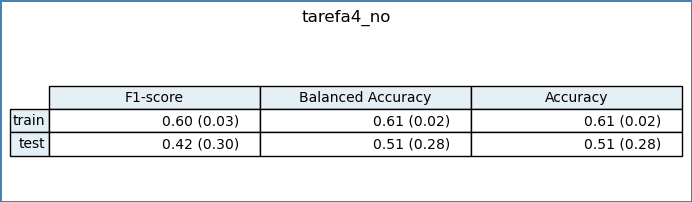

In [5]:
saver.toImage()